# For spline (two-model) method training only

### Import necessary packages and self-defined classes

In [1]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
# Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math
import scipy.interpolate
# self-defined model
from model_pic import *
from model_cal import *
from model_one import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

### Augamented dataset loading and preprocessing

In [2]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.9, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

In [5]:
data_matrix_augmentation = pd.read_csv("Data_uniform/Data_aug/Spline_coef_aug.csv", header= None)
print(data_matrix_augmentation)

# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self,dataInput):
        x = dataInput.iloc[0:,3:].values
        y = dataInput.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = dataInput.iloc[:,0].values
        y1 = dataInput.iloc[:,1].values
        
        # Plot surface tension histogram
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension[mN/m]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Surface Tension')\

        # Plot volume histogram
        # n, bins, patches = plt.hist(x=y1, bins='auto', color='#0504aa',
        #                             alpha=0.7, rwidth=0.85)
        # plt.grid(axis='y', alpha=0.75)
        # plt.xlabel('Volume[mm^3]')
        # plt.ylabel('Frequency')
        # plt.title('Occurence of data per Volume')

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        

          0         1          2         3         4         5         6   \
0       15.1   5.10061  14.150364  1.343070  0.560755 -0.204328 -0.058190   
1       15.1   5.10061  14.150364 -0.161344  0.560755 -0.204328 -0.058190   
2       15.1   5.10061  14.150364  0.442829  0.560755 -0.204328 -0.058190   
3       15.1   5.10061  14.150364  1.403207  0.560755 -0.204328 -0.058190   
4       15.1   5.20122  13.846032  0.061767  0.560057 -0.206831 -0.056986   
...      ...       ...        ...       ...       ...       ...       ...   
109539  93.2  44.81438  42.599241  1.326978  0.438854 -0.652535  0.146285   
109540  93.2  45.39140  43.012347  1.657659  0.451419 -0.664851  0.125092   
109541  93.2  45.39140  43.012347  1.722307  0.451419 -0.664851  0.125092   
109542  93.2  45.39140  43.012347  0.943215  0.451419 -0.664851  0.125092   
109543  93.2  45.39140  43.012347  1.005774  0.451419 -0.664851  0.125092   

              7         8         9   ...        15        16        17  \


### Load data for PictureNet
Read image from files

In [2]:
train_img = []
data_matrix_augmentation = pd.read_csv("Data_uniform/Data_aug/Spline_coef_aug.csv", header= None)
data_image_augmentation = data_matrix_augmentation

for img_name in data_image_augmentation.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/Data_aug/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    if img_name%1000 ==0:
        print(img_name)
    img = np.array(img)
    # appending the image into the list
    train_img.append(img)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


Plot a single image for viewing

Current image = 9392
Picture size = (82, 77)


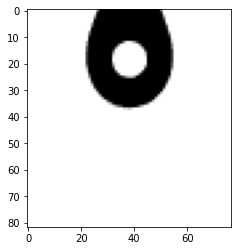

In [ ]:
""" rand = random.randint(1, 100000)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')
 """

Define the function

In [ ]:
# Split and transfer the data from list to torch format
def split_n_transfer(x, y):
    # Points data split
    train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(x, y, test_size = 0.2)    # default shuffle = True
    val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

    # converting the train images of points and targets into torch format
    train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
    train_x_pic = torch.from_numpy(train_x_pic)
    train_y_pic = torch.from_numpy(train_y_pic)

    # converting the val images and target points into torch format
    val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
    val_x_pic = torch.from_numpy(val_x_pic)
    val_y_pic = torch.from_numpy(val_y_pic)
    # print(val_x_pic.shape, val_y_pic.shape)

    # converting the test images and targets into torch format for points
    test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
    test_x_pic  = torch.from_numpy(test_x_pic)
    test_y_pic = torch.from_numpy(test_y_pic)
    # print(test_x_pic.shape, test_y_pic.shape)
    
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

# converting all raw datasets into batch datasets in the same time
def batch_all(train_x, train_y, val_x, val_y, test_x, test_y):
    train_x_pic = batch_transform(train_x)
    train_y_pic = batch_transform(train_y)
    val_x_pic = batch_transform(val_x)
    val_y_pic = batch_transform(val_y)
    test_x_pic = batch_transform(test_x)
    test_y_pic = batch_transform(test_y)
    return train_x_pic, train_y_pic, val_x_pic, val_y_pic, test_x_pic, test_y_pic

Create and splite the dataset for edge point model

In [ ]:
# converting the list to numpy array
#train_x_pic = np.array(train_img)
train_y_pic_augmentation = data_image_augmentation.iloc[0:,3:].values

train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation = \
    split_n_transfer(train_x_pic, train_y_pic_augmentation)

train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation = \
    batch_all(train_x_pic_augmentation, train_y_pic_augmentation, val_x_pic_augmentation, val_y_pic_augmentation, test_x_pic_augmentation, test_y_pic_augmentation)
    
print(len(train_x_pic_augmentation), len(train_y_pic_augmentation), len(val_x_pic_augmentation), \
    len(val_y_pic_augmentation), len(test_x_pic_augmentation), len(test_y_pic_augmentation))


### Deside to apply host or device


In [ ]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


## Define the functions for models

In [ ]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0 and ~(os.path.isdir(path)):
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    
    # model selection depends on data type
    if model_input == 0:
        train_loader = train_loader_points
        val_loader = val_loader_points
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_points.pt")
    elif model_input == 1:
        train_loader = train_loader
        val_loader = val_loader
        PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    else:
        ValueError("Incorrect input: 0 for edge point model, 1 for spline model")

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1, model_input=0):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0

    # model selection depends on data type
    
    train_x_pic = train_x_pic_augmentation
    train_y_pic = train_y_pic_augmentation
    val_x_pic = val_x_pic_augmentation
    val_y_pic = val_y_pic_augmentation
    PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")


    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PictureNet for spline

In [ ]:
#Initialize
""" in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 22

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200 """

#Retrain

PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")

model_picture_trained = torch.load(PATH_PIC)

learning_rate = 1e-3
epoch = 200

optimizer = optim.Adam(model_picture_trained.parameters(), lr=learning_rate)


# 0 indicates edge points 1 indicates spline
train_picture(model_picture_trained, optimizer, epoch, 1)
